# Visualizing what Convolutional Neural Networks learn

Dataset: MNIST, images of digits.

Train an Convolutional Neural Network to classify these images. We have chosen a very sparse design with only 8 3x3 filters in the first convolutional layer and 16 in the second convolutional layer. Nonetheless the network reaches an accuracy of 91\% on the test set.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, Input, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random

In [2]:
dataset = keras.datasets.mnist
(X_train,y_train),(X_test,y_test)= dataset.load_data()

X_train, X_test = 2*(X_train/255.)-1 , 2*(X_test/255.)-1.

In [3]:
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

# Designing the classifier

We design the neural network using Convolutional, Pooling, and Dense layers. We also use dropout and Batch Normalization.

The resulting neural network has roughly the same number of parameters $(\sim 400,000)$ as the MLP. It reaches a train set

accuracy of 93\% vs the MLP accuracy of 88.6\%.

In [4]:
regularizer = tf.keras.regularizers.L1L2(l1=1e-5,l2=1e-4)
def build_model(inputShape,n_classes):
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(8, (3, 3), padding="same", activation="relu",
               kernel_regularizer=regularizer)(inputs)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(16, (3, 3), padding="same", activation="relu",
               kernel_regularizer=regularizer)(x)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # third set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(16, (3, 3), padding="same", activation="relu",
               kernel_regularizer=regularizer)(x)
    #x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # prepare the final outputs
    unrolled= Flatten()(x)
    unrolled= Dense(16,activation='relu',
                    kernel_regularizer=regularizer)(unrolled)
    output = Dense(n_classes,activation='softmax')(unrolled)
    # build the model
    model = Model(inputs, output)
    # return the model to the calling function
    return model

In [5]:
numclasses = len(np.unique(y_train))
model=build_model(X_train[0].shape,numclasses)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
              metrics =['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 16)        0     

# Training the Neural Network

We now train the model using $\mathtt{model.fit}$. Note the argument _validation_split_ passed to this function. 

Neural networks are typically trained while comparing with the validation data at each epoch. This gives us a monitor of possible overfitting even while the network is training.

We can also use this monitor as a means to control overfitting, see _early stopping_

In [6]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience=3,
                                                verbose=1,
                                                restore_best_weights=True)

epochs = 50
batch_size = 32

history = model.fit(X_train,y_train,validation_split=0.1,
                    epochs=epochs,batch_size = batch_size,
                   callbacks=[early_stopping])

Epoch 1/50
1688/1688 [==============================] - 86s 51ms/step - loss: 0.3596 - accuracy: 0.9066 - val_loss: 0.1612 - val_accuracy: 0.9688
Epoch 2/50
1688/1688 [==============================] - 83s 49ms/step - loss: 0.1501 - accuracy: 0.9698 - val_loss: 0.1229 - val_accuracy: 0.9802
Epoch 3/50
1688/1688 [==============================] - 87s 52ms/step - loss: 0.1316 - accuracy: 0.9771 - val_loss: 0.1112 - val_accuracy: 0.9865
Epoch 4/50
1688/1688 [==============================] - 85s 50ms/step - loss: 0.1199 - accuracy: 0.9799 - val_loss: 0.1086 - val_accuracy: 0.9848
Epoch 5/50
1688/1688 [==============================] - 82s 48ms/step - loss: 0.1127 - accuracy: 0.9827 - val_loss: 0.1237 - val_accuracy: 0.9842
Epoch 6/50
1688/1688 [==============================] - 52s 31ms/step - loss: 0.1076 - accuracy: 0.9839 - val_loss: 0.1056 - val_accuracy: 0.9860
Epoch 7/50
1688/1688 [==============================] - 56s 33ms/step - loss: 0.1036 - accuracy: 0.9851 - val_loss: 0.1087 -

# Results

We reached a training loss of about 0.28 and validation loss of 0.35. Regularization, Dropout and Batch Normalization mitigate overfitting in the neural network. Indeed the model reaches an accuracy of 0.94 on the train data while the accuracy on the validation data is 0.92, roughly comparable.

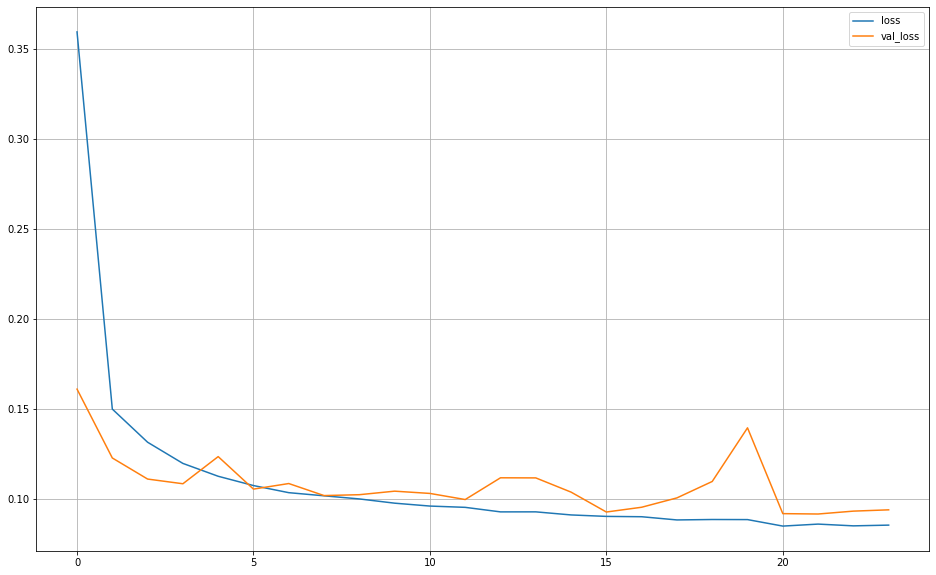

In [7]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(16, 10))
plt.grid(True)
plt.show()

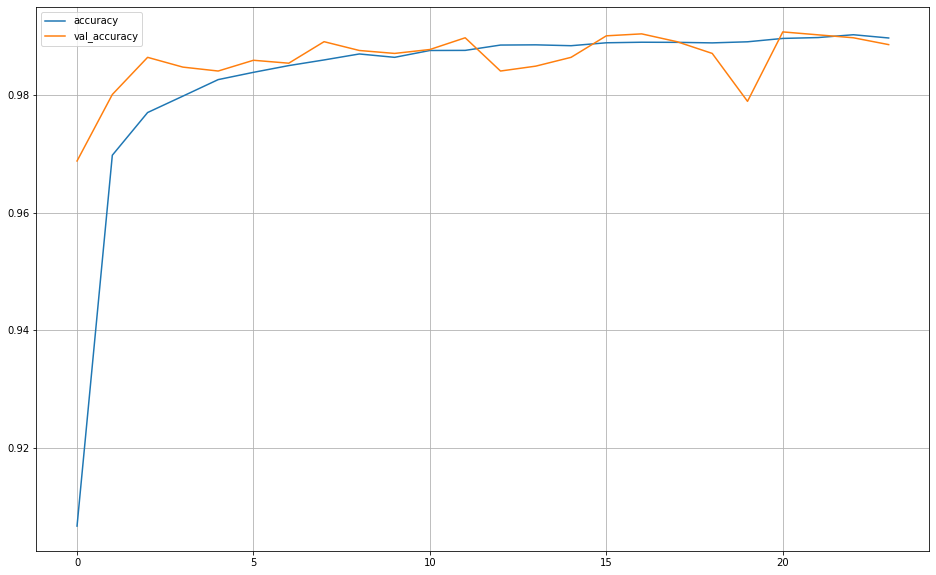

In [8]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(figsize=(16, 10))
plt.grid(True)
plt.show()

In [9]:
model.save('mnist_convnet.h5')

## Evaluating the model

The validation data above was supposed to be a placeholder for actual unseen data. We estimate that the model should reach a loss of 0.34 and an accuracy of 0.89 on unseen data.

We can check this by evaluating the model on test data. The actual numbers are not too far off from our expectations. The loss is 0.37 and the accuracy is 0.88

In [10]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.0945 - accuracy: 0.9870
Test loss: 0.09446333348751068
Test accuracy: 0.9869999885559082


In [11]:
y_pred = np.argmax(model.predict(X_test),axis=-1)
print(confusion_matrix(y_test,y_pred))

[[ 978    0    0    0    0    0    1    0    0    1]
 [   0 1130    0    1    1    0    0    3    0    0]
 [  13    7  989    1    1    0    3   13    4    1]
 [   1    1    0  996    0    6    0    3    2    1]
 [   0    0    0    0  980    0    0    0    0    2]
 [   1    1    0    2    0  885    1    1    1    0]
 [   5    2    0    0    7    4  938    0    2    0]
 [   0    1    1    0    2    0    0 1022    1    1]
 [   5    0    0    1    0    0    0    1  965    2]
 [   1    0    0    0   14    1    0    2    4  987]]


# Visualizing what Convolutional Networks have learnt

In [12]:
model = tf.keras.models.load_model('mnist_convnet.h5')

In [13]:
layer_outputs = [layer.output for layer in model.layers]
layer_names = [layer.name for layer in model.layers]

In [14]:
activation_model = Model(inputs=model.input,outputs=layer_outputs)

In [15]:
n_test = len(y_test)
im_idx = np.where(y_test==8)[0]
imgs=X_test[im_idx]

activations = activation_model.predict(imgs)
[a.shape for a in activations]

[(974, 28, 28, 1),
 (974, 28, 28, 8),
 (974, 28, 28, 8),
 (974, 28, 28, 8),
 (974, 28, 28, 16),
 (974, 28, 28, 16),
 (974, 28, 28, 16),
 (974, 28, 28, 16),
 (974, 28, 28, 16),
 (974, 28, 28, 16),
 (974, 12544),
 (974, 16),
 (974, 10)]

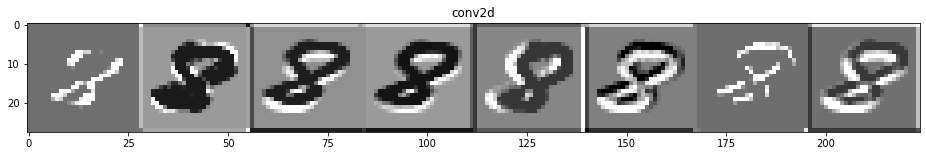

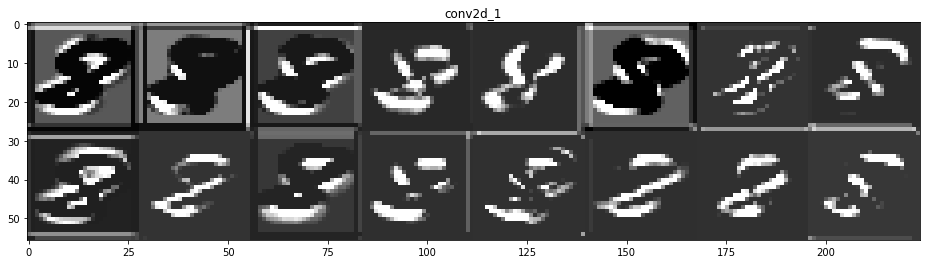

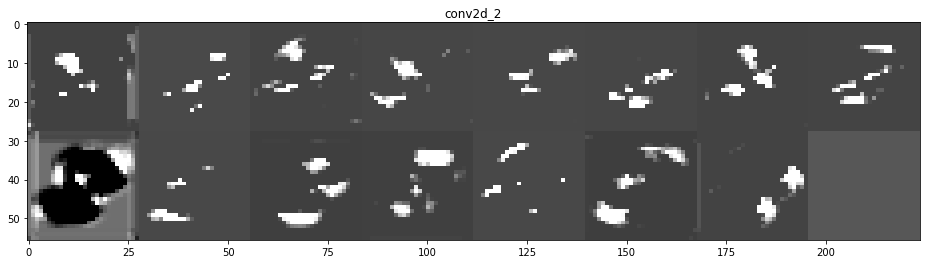

In [16]:
images_per_row = 8
for layer_name, activation in zip(layer_names,activations):
    eps = 1e-6 # avoid dividing by zero
    if 'conv2d' in layer_name:
        n_features = activation.shape[-1]
        size = activation.shape[1]
        n_cols = n_features // images_per_row
        n_rows = images_per_row
        display_grid = np.zeros((size*n_cols,size*n_rows))
        for col in range(n_cols):
            for row in range(n_rows):
                index = col * n_rows + row
                channel_image = activation[0,:,:,index]
                channel_image -= channel_image.mean()
                channel_image /= (channel_image.std()+eps)
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image,0,255).astype('uint8')
                display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
        scale = 2./size
        plt.figure(figsize = (scale*display_grid.shape[1],scale*display_grid.shape[0]))
        plt.title(layer_name)
        #plt.grid(True)
        plt.imshow(display_grid,aspect='auto',cmap='binary_r')
        plt.show()

The innermost layer, closest to the input image appears to consist of edge detectors. Almost all the information in the image is retained. The deeper layers consist of increasingly abstract patterns associated to the figure 8. The black spots in the image are areas where the pattern is absent, hence, the filter does not activate. 

As a result, we can make out that the convnet starts by processing the information in the input image and extracting abstract patters which by themselves may not have a meaning but are associated with the digits we would like to classify.